In [122]:
#Importing Libraries
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
import pickle as pkl 
import warnings 
warnings.filterwarnings('ignore')

In [130]:
dataset = pd.read_csv("loan_approval_dataset.csv")

#-------------------------Data Preprocessing-----------------------------------------#

#dataset normalization replacing to lowercase and removing extra space
dataset.columns = dataset.columns.str.strip().str.lower().str.replace(" ", "_")
print("=== Initial Dataset Preview ===")
print(dataset.head(), "\n")
rows, cols = dataset.shape
print(f"Dataset shape: {rows} rows, {cols} columns")
print("Columns:", list(dataset.columns), "\n")

#removing empty rows
print(f"Rows before cleaning: {len(dataset)}")
dataset = dataset.dropna()
print(f"Rows after cleaning: {len(dataset)}")

#combining columns having same kind of features
dataset["assets"] = (dataset.residential_assets_value + 
                    dataset.commercial_assets_value + 
                    dataset.luxury_assets_value + 
                    dataset.bank_asset_value)

#dropping useless columns
dataset.drop(columns = ["loan_id" , "residential_assets_value","commercial_assets_value",
                       "luxury_assets_value", "bank_asset_value"], inplace = True)

print("Final columns:", list(dataset.columns), "\n")

#dataset binary classification
dataset["education"] = dataset["education"].str.strip().str.lower()
dataset["education"] = dataset["education"].replace(["graduate" , "not graduate"], [1,0])

dataset["self_employed"] = dataset["self_employed"].str.strip().str.lower()
dataset["self_employed"] = dataset["self_employed"].replace(["yes","no"],[1,0])

dataset["loan_status"] = dataset["loan_status"].str.strip().str.lower()
dataset["loan_status"] = dataset["loan_status"].replace(["approved","rejected"],[1,0])


=== Initial Dataset Preview ===
   loan_id  no_of_dependents      education self_employed  income_annum  \
0        1                 2       Graduate            No       9600000   
1        2                 0   Not Graduate           Yes       4100000   
2        3                 3       Graduate            No       9100000   
3        4                 3       Graduate            No       8200000   
4        5                 5   Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
0                 17600000  

C:\Users\SHAJ\AppData\Local\Temp\ipykernel_11580\2040069359.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["education"] = dataset["education"].replace(["graduate" , "not graduate"], [1,0])
C:\Users\SHAJ\AppData\Local\Temp\ipykernel_11580\2040069359.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["self_employed"] = dataset["self_employed"].replace(["yes","no"],[1,0])
C:\Users\SHAJ\AppData\Local\Temp\ipykernel_11580\2040069359.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will b

In [131]:
# ---------------- Train Test Split ---------------- #
# Ensure proper column order for web app compatibility
feature_order = ['no_of_dependents', 'education', 'self_employed', 
                'income_annum', 'loan_amount', 'loan_term', 
                'cibil_score', 'assets']

# Reorder columns to match web app expectations
X = dataset[feature_order]
y = dataset["loan_status"]

print(f"\n=== Feature Matrix Info ===")
print(f"Features shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"Target shape: {y.shape}")

# Split data first, then apply SMOTE only to training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training target distribution:\n{y_train.value_counts()}")

# ---------------- Scaling ---------------- #
print("\n=== Feature Scaling ===")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed successfully")
print(f"Scaled training data shape: {X_train_scaled.shape}")

# ---------------- Model Training (Without SMOTE) ---------------- #
print("\n=== Training Model Without SMOTE ===")
model = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)


=== Feature Matrix Info ===
Features shape: (4269, 8)
Features: ['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'assets']
Target shape: (4269,)

Train set size: 3415
Test set size: 854
Training target distribution:
loan_status
1    2125
0    1290
Name: count, dtype: int64

=== Feature Scaling ===
Scaling completed successfully
Scaled training data shape: (3415, 8)

=== Training Model Without SMOTE ===


Accuracy (No SMOTE): 0.9133

Classification Report (No SMOTE):
              precision    recall  f1-score   support

           0     0.9055    0.8607    0.8825       323
           1     0.9177    0.9454    0.9314       531

    accuracy                         0.9133       854
   macro avg     0.9116    0.9030    0.9069       854
weighted avg     0.9131    0.9133    0.9129       854



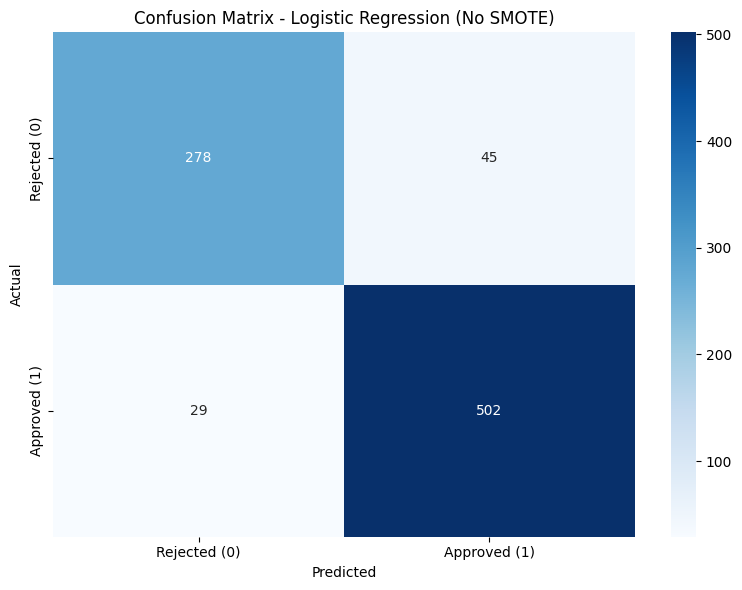

In [132]:
# Metrics
accuracy_base = accuracy_score(y_test, y_pred)
print(f"Accuracy (No SMOTE): {accuracy_base:.4f}")
print(f"\nClassification Report (No SMOTE):\n{classification_report(y_test, y_pred, digits=4)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Rejected (0)", "Approved (1)"], 
            yticklabels=["Rejected (0)", "Approved (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (No SMOTE)")
plt.tight_layout()
plt.show()


=== Applying SMOTE for Class Balance ===
Before SMOTE: {0: np.int64(1290), 1: np.int64(2125)}
After SMOTE : {0: np.int64(2125), 1: np.int64(2125)}

=== Training Model With SMOTE ===
Accuracy (With SMOTE): 0.9227

Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0     0.8813    0.9195    0.9000       323
           1     0.9497    0.9247    0.9370       531

    accuracy                         0.9227       854
   macro avg     0.9155    0.9221    0.9185       854
weighted avg     0.9238    0.9227    0.9230       854



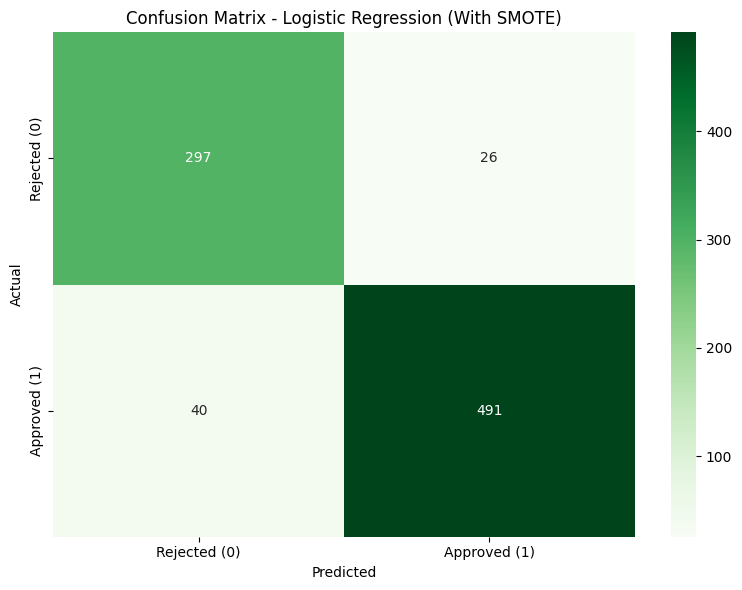


=== Model Comparison ===
Base Model Accuracy: 0.9133
SMOTE Model Accuracy: 0.9227
Improvement: 0.0094

=== Feature Importance (SMOTE Model) ===
            feature  coefficient  abs_coefficient
6       cibil_score     4.387241         4.387241
3      income_annum    -1.570152         1.570152
4       loan_amount     1.390576         1.390576
5         loan_term    -0.811913         0.811913
7            assets     0.300509         0.300509
1         education     0.067691         0.067691
0  no_of_dependents    -0.058648         0.058648
2     self_employed     0.016343         0.016343


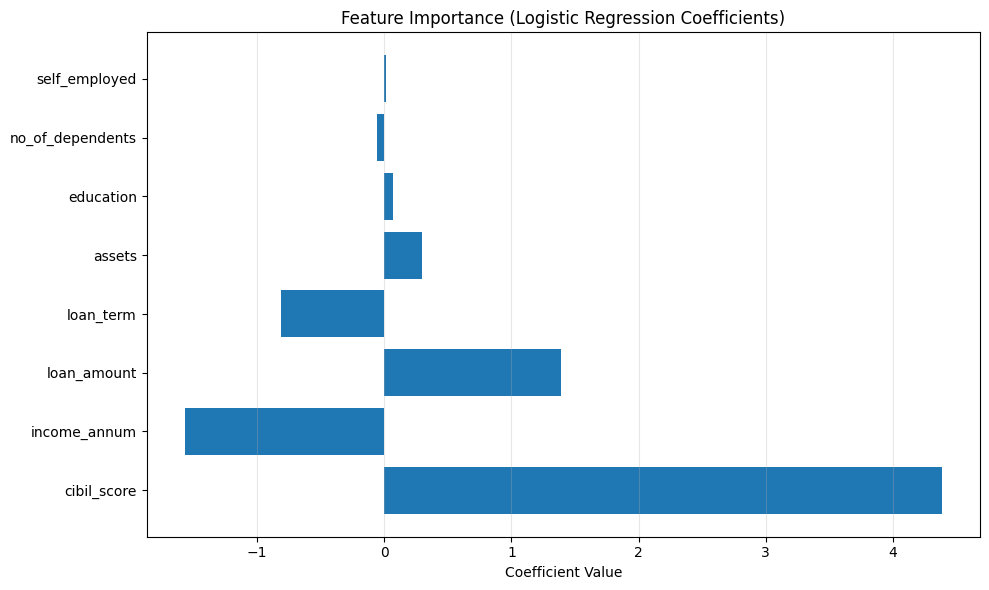

In [133]:
#-------------------SMOTE Oversampling-------------------#
print("\n=== Applying SMOTE for Class Balance ===")

# Apply SMOTE to training data only (after scaling)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", dict(y_train.value_counts().sort_index()))
print("After SMOTE :", dict(pd.Series(y_train_res).value_counts().sort_index()))

# Retrain Logistic Regression with balanced data
print("\n=== Training Model With SMOTE ===")
model_smote = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=42)
model_smote.fit(X_train_res, y_train_res)

# Predictions on test set
y_pred_smote = model_smote.predict(X_test_scaled)

# Accuracy & Classification Report
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy (With SMOTE): {accuracy_smote:.4f}")
print(f"\nClassification Report (With SMOTE):\n{classification_report(y_test, y_pred_smote, digits=4)}")

# Confusion Matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Rejected (0)", "Approved (1)"],
            yticklabels=["Rejected (0)", "Approved (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (With SMOTE)")
plt.tight_layout()
plt.show()

# Model Comparison
print("\n=== Model Comparison ===")
print(f"Base Model Accuracy: {accuracy_base:.4f}")
print(f"SMOTE Model Accuracy: {accuracy_smote:.4f}")
print(f"Improvement: {accuracy_smote - accuracy_base:.4f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_order,
    'coefficient': model_smote.coef_[0],
    'abs_coefficient': np.abs(model_smote.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n=== Feature Importance (SMOTE Model) ===")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [139]:
print("\n=== Saving Models and Scaler ===")

try:
    # Save the better performing model (you can choose based on your needs)
    if accuracy_smote > accuracy_base:
        print("Saving SMOTE model as primary model")
        pkl.dump(model_smote, open("model.pkl", "wb"))
        best_model = "SMOTE"
    else:
        print("Saving base model as primary model")
        pkl.dump(model, open("model.pkl", "wb"))
        best_model = "Base"
    
    # Save both models for comparison
    pkl.dump(model, open("model_base.pkl", "wb"))
    pkl.dump(model_smote, open("model_smote.pkl", "wb"))
    pkl.dump(scaler, open("scaler.pkl", "wb"))
    
    print("✅ All models and scaler saved successfully!")
    print(f"Primary model: {best_model}")
    
    # Verify saved files
    print("\n=== Verification: Loading Saved Models ===")
    loaded_model = pkl.load(open("model.pkl", "rb"))
    loaded_scaler = pkl.load(open("scaler.pkl", "rb"))
    
    # Test with sample data
    sample_data = pd.DataFrame([[2, 1, 0, 600000, 1500000, 60, 750, 2000000]], 
                              columns=feature_order)
    sample_scaled = loaded_scaler.transform(sample_data)
    sample_pred = loaded_model.predict(sample_scaled)
    sample_proba = loaded_model.predict_proba(sample_scaled)
    
    print(f"Test prediction: {sample_pred[0]} (Probabilities: {sample_proba[0]})")
    print("✅ Model verification successful!")
    
except Exception as e:
    print(f"❌ Error saving models: {e}")

#---------Web App Compatibility Check----------------------#
print("\n=== Web App Compatibility Check ===")
print("Required feature order for web app:")
print(feature_order)
print("\nFeature data types:")
for i, feature in enumerate(feature_order):
    if feature in X.columns:
        dtype = X[feature].dtype
        sample_val = X[feature].iloc[0]
        print(f"{i+1}. {feature}: {dtype} (sample: {sample_val})")
    else:
        print(f"❌ Missing feature: {feature}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Final Model Accuracy: {max(accuracy_base, accuracy_smote):.4f}")
print("Files created:")
print("- model.pkl (primary model)")
print("- model_base.pkl (base model)")  
print("- model_smote.pkl (SMOTE model)")
print("- scaler.pkl (feature scaler)")
print("\n🚀 Ready to deploy with Streamlit app!")


=== Saving Models and Scaler ===
Saving SMOTE model as primary model
✅ All models and scaler saved successfully!
Primary model: SMOTE

=== Verification: Loading Saved Models ===
Test prediction: 0 (Probabilities: [0.85168927 0.14831073])
✅ Model verification successful!

=== Web App Compatibility Check ===
Required feature order for web app:
['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'assets']

Feature data types:
1. no_of_dependents: int64 (sample: 2)
2. education: int64 (sample: 1)
3. self_employed: int64 (sample: 0)
4. income_annum: int64 (sample: 9600000)
5. loan_amount: int64 (sample: 29900000)
6. loan_term: int64 (sample: 12)
7. cibil_score: int64 (sample: 778)
8. assets: int64 (sample: 50700000)

MODEL TRAINING COMPLETED SUCCESSFULLY!
Final Model Accuracy: 0.9227
Files created:
- model.pkl (primary model)
- model_base.pkl (base model)
- model_smote.pkl (SMOTE model)
- scaler.pkl (feature scaler)

🚀 Ready to depl


=== Saving Models and Scaler ===
Saving SMOTE model as primary model
✅ All models and scaler saved successfully!
Primary model: SMOTE

=== Verification: Loading Saved Models ===
Test prediction: 0 (Probabilities: [0.85168927 0.14831073])
✅ Model verification successful!

=== Web App Compatibility Check ===
Required feature order for web app:
['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'assets']

Feature data types:
1. no_of_dependents: int64 (sample: 2)
2. education: int64 (sample: 1)
3. self_employed: int64 (sample: 0)
4. income_annum: int64 (sample: 9600000)
5. loan_amount: int64 (sample: 29900000)
6. loan_term: int64 (sample: 12)
7. cibil_score: int64 (sample: 778)
8. assets: int64 (sample: 50700000)

MODEL TRAINING COMPLETED SUCCESSFULLY!
Final Model Accuracy: 0.9227
Files created:
- model.pkl (primary model)
- model_base.pkl (base model)
- model_smote.pkl (SMOTE model)
- scaler.pkl (feature scaler)

Ready to deploy